***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [4]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [5]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [6]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [7]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [8]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [9]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [10]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [11]:
df=pd.read_csv('Javascript.csv')

df.rename(columns={'Malicious':'Target'},inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
display(df.head())
print("Shape of our dataset:",df.shape)

,dom_function_document.adoptNode(,dom_function_document.captureEvents(,dom_function_document.caretPositionFromPoint(,dom_function_document.caretRangeFromPoint(,dom_function_document.clear(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createAttributeNS(,dom_function_document.createCDATASection(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEntityReference(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTouch(,dom_function_document.createTouchList(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.enableStyleSheetsForSet(,dom_function_document.execCommand(,dom_function_document.exitPointerLock(,dom_function_document.getAnimations(,dom_function_document.getElementById(,dom_function_document.getElementByName(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getElementsByTagNameNS(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.normalizeDocument(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.queryCommandIndeterm(,dom_function_document.queryCommandValue(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.releaseCapture(,dom_function_document.releaseEvent(,dom_function_document.routeEvent(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.back(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.cancelIdleCallback(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.createImageBitmap(,dom_function_window.disableExternalCapture(,dom_function_window.dispatchEvent(,dom_function_window.dump(,dom_function_window.enableExternalCapture(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.forward(,dom_function_window.getAttention(,dom_function_window.getAttentionWithCycleCount(,dom_function_window.getComputedStyle(,dom_function_window.getDefaultComputedSyle(,dom_function_window.getSelection(,dom_function_window.home(,dom_function_window.matchMedia(,dom_function_window.maximize(,dom_function_window.minimize(,dom_function_window.moveBy(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.openDialog(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.releaseEvents(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.requestIdleCallback(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.restore(,dom_function_window.routeEvent(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollByLines(,dom_function_window.scrollByPages(,dom_function_window.scrollTo(,dom_function_window.setCursor(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setResizable(,dom_function_window.setTimeout(,dom_function_window.sizeToContent(,dom_function_window.stop(,dom_function_window.updateCommands(,js_function_.add(,js_function_.all(,js_function_.allTrue(,js_function_.anchor(,js_function_.apply(,js_function_.big(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_funct

Shape of our dataset: (43294, 401)


#### Let us analyze the balance of classes

In [12]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [13]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        print(col)
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))

### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

dom_function_document.adoptNode(
dom_function_document.caretPositionFromPoint(
dom_function_document.caretRangeFromPoint(
dom_function_document.clear(
dom_function_document.createAttributeNS(
dom_function_document.createCDATASection(
dom_function_document.createEntityReference(
dom_function_document.createTouch(
dom_function_document.createTouchList(
dom_function_document.enableStyleSheetsForSet(
dom_function_document.exitPointerLock(
dom_function_document.getAnimations(
dom_function_document.getElementByName(
dom_function_document.getElementsByTagNameNS(
dom_function_document.normalizeDocument(
dom_function_document.queryCommandIndeterm(
dom_function_document.queryCommandValue(
dom_function_document.releaseCapture(
dom_function_document.releaseEvent(
dom_function_document.routeEvent(
dom_function_window.back(
dom_function_window.cancelIdleCallback(
dom_function_window.createImageBitmap(
dom_function_window.disableExternalCapture(
dom_function_window.dump(
dom_function_window.enableExt

In [14]:
### Check and converting data types
df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)

print("Columns which are of type object:",df.dtypes[(df.dtypes=='object')])

Columns which are of type object: Series([], dtype: object)


#### Check for missing data

In [15]:
df.isnull().sum()

dom_function_document.captureEvents(                  0
dom_function_document.close(                          0
dom_function_document.createAttribute(                0
dom_function_document.createComment(                  0
dom_function_document.createDocumentFragment(         0
dom_function_document.createElement(                  0
dom_function_document.createElementNS(                0
dom_function_document.createEvent(                    0
dom_function_document.createNodeIterator(             0
dom_function_document.createProcessingInstruction(    0
dom_function_document.createRange(                    0
dom_function_document.createTextNode(                 0
dom_function_document.createTreeWalker(               0
dom_function_document.elementFromPoint(               0
dom_function_document.elementsFromPoint(              0
dom_function_document.execCommand(                    0
dom_function_document.getElementById(                 0
dom_function_document.getElementsByClassName(   

#### No missing data exists

#### Next check to see which features have less than 5% varying data

In [16]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

234 columns have more than 95% same values


In [17]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [18]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
display(columns.tolist())
columns=columns.tolist()+['Target']

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substr',
 'js_function_.substring(',
 'js_function_.test(

#### lets see if for the rest of continuous variables if there exists any relationship using Point biserial correlation.
####  The PointBiserial Correlation is a special case of Pearson co-rrelation for Correlation between continuous and dichotomus binary variable. 

In [19]:
df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for JavaScript experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for JavaScript experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for JavaScript experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
dom_function_document.getElementsByTagName(,-0.206833,0.000000e+00,-94.422955,0.000000e+00
dom_function_document.createElement(,-0.154604,9.233651e-230,-72.422095,0.000000e+00
js_function_.getTime(,-0.149504,8.006211e-215,-70.045384,0.000000e+00
dom_function_window.addEventListener(,-0.107093,1.299881e-110,-51.397683,0.000000e+00
js_function_.split(,-0.097541,5.300145e-92,-46.252895,0.000000e+00
js_function_Math.random(,-0.094978,2.620317e-87,-44.513654,0.000000e+00
js_function_.setTime(,-0.083818,2.410642e-68,-41.813198,0.000000e+00
js_function_.replace(,-0.087844,6.536777e-75,-38.924200,0.000000e+00
js_function_.indexOf(,-0.075600,6.618535e-56,-36.469099,9.453374e-287



Stats for Categorical features for JavaScript experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


#### The ttest conduncted supports the results of point biserial correlation. 

#### Hence, we see that all the features we selected are related to the dependent variable.

### Lets start by building some basic models 

In [20]:
columns.remove('Target')

In [21]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [22]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [23]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [24]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.839468745489
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24355  5270    29625
True         290  4720     5010
__all__    24645  9990    34635

Accuracy of the KNN model for twst data is: 0.836586210879
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6064  1319     7383
True          96  1180     1276
__all__     6160  2499     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.855233145662
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29605    20    29625
True        4994    16     5010
__all__    34599    36    34635

Accuracy of the Logistic Regression model for twst data is: 0.851830465412
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7373    10     7383
True        1273     3     1276
__all__     8646    13     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.864154756749
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29575    50    29625
True        4655   355     5010
__all__    34230   405    34635

Accuracy of the Random Forest Classifier for twst data is: 0.856334449706
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7359    24     7383
True        1220    56     1276
__all__     8579    80     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.852490255522
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29498   127    29625
True        4982    28     5010
__all__    34480   155    34635

Accuracy of the Ada Boost Classifier for twst data is: 0.848712322439
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7344    39     7383
True        1271     5     1276
__all__     8615    44     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.858640103941
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29603    22    29625
True        4874   136     5010
__all__    34477   158    34635

Accuracy of the Gradient Boosting Classifier for twst data is: 0.854948608384
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7371    12     7383
True        1244    32     1276
__all__     8615    44     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.865136422694
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29579    46    29625
True        4625   385     5010
__all__    34204   431    34635

Accuracy of the Extra Tree Classifier for twst data is: 0.856680910036
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7359    24     7383
True        1217    59     1276
__all__     8576    83     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.864125884221
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29575    50    29625
True        4656   354     5010
__all__    34231   404    34635

Accuracy of the Bagging model for twst data is: 0.855987989375
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7351    32     7383
True        1215    61     1276
__all__     8566    93     8659



Neural Network-1
The accuracy of the model on training data is: 0.862855492997


Predicted  False  True  __all__
Actual                         
False      29579    46    29625
True        4704   306     5010
__all__    34283   352    34635

The accuracy of the model on test data is: 0.855526042268


Predicted  False  True  __all__
Actual                         
False       7356    27     7383
True        1224    52     1276
__all__     8580    79     8659

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [25]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [26]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.839469,4720.0,24355.0,5270.0,290.0,0.177890,0.057884
LogisticRegression,0.855233,16.0,29605.0,20.0,4994.0,0.000675,0.996806
RandomForestClassifier,0.864155,355.0,29575.0,50.0,4655.0,0.001688,0.929142
AdaBoostClassifier,0.852490,28.0,29498.0,127.0,4982.0,0.004287,0.994411
GradientBoostingClassifier,0.858640,136.0,29603.0,22.0,4874.0,0.000743,0.972854
ExtraTreeClassifier,0.865136,385.0,29579.0,46.0,4625.0,0.001553,0.923154
BaggingClassifier,0.864126,354.0,29575.0,50.0,4656.0,0.001688,0.929341
Neural Network-1,0.862855,306.0,29579.0,46.0,4704.0,0.001553,0.938922


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.836586,1180.0,6064.0,1319.0,96.0,0.178654,0.075235,0.873056
LogisticRegression,0.851830,3.0,7373.0,10.0,1273.0,0.001354,0.997649,0.500498
RandomForestClassifier,0.856334,56.0,7359.0,24.0,1220.0,0.003251,0.956113,0.520318
AdaBoostClassifier,0.848712,5.0,7344.0,39.0,1271.0,0.005282,0.996082,0.499318
GradientBoostingClassifier,0.854949,32.0,7371.0,12.0,1244.0,0.001625,0.974922,0.511727
ExtraTreeClassifier,0.856681,59.0,7359.0,24.0,1217.0,0.003251,0.953762,0.521494
BaggingClassifier,0.855988,61.0,7351.0,32.0,1215.0,0.004334,0.952194,0.521736
Neural Network-1,0.855526,52.0,7356.0,27.0,1224.0,0.003657,0.959248,0.521736


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [27]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [28]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [29]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 43294, Columns: 54]
  Relationships:
    No relationships

In [30]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 5565 features
EntitySet scattered to workers in 10.593 seconds
Elapsed: 01:12 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [31]:
feature_matrix_sessions.head()

,dom_function_document.createElement(,dom_function_document.getElementById(,dom_function_document.getElementsByTagName(,dom_function_document.querySelector(,dom_function_document.write(,dom_function_window.addEventListener(,dom_function_window.open(,dom_function_window.setTimeout(,js_function_.add(,js_function_.apply(,js_function_.bind(,js_function_.call(,js_function_.charAt(,js_function_.concat(,js_function_.defineProperty(,js_function_.exec(,js_function_.find(,js_function_.forEach(,js_function_.get(,js_function_.getTime(,js_function_.hasOwnProperty(,js_function_.indexOf(,js_function_.join(,js_function_.keys(,js_function_.log(,js_function_.match(,js_function_.pop(,js_function_.push(,js_function_.replace(,js_function_.setTime(,js_function_.shift(,js_function_.slice(,js_function_.split(,js_function_.substr,js_function_.substring(,js_function_.test(,js_function_.toLowerCase(,js_function_.toString(,js_function_.trim(,js_function_JSON.parse(,js_function_JSON.stringify(,js_function_Math.floor(,js_function_Math.max(,js_function_Math.random(,js_function_Math.round(,js_function_Object.defineProperty(,js_function_Object.keys(,js_function_decodeURIComponent(,js_function_encodeURIComponent(,js_function_escape(,js_function_isNaN(,js_function_parseInt(,js_function_unescape(,dom_function_window.open( + js_function_Object.keys(,dom_function_document.createElement( + dom_function_document.write(,js_function_.defineProperty( + js_function_.trim(,dom_function_document.querySelector( + js_function_.push(,js_function_.join( + js_function_.shift(,js_function_.bind( + js_function_isNaN(,dom_function_document.getElementById( + js_function_.defineProperty(,js_function_.pop( + js_function_decodeURIComponent(,js_function_.bind( + js_function_.replace(,js_function_.toLowerCase( + js_function_unescape(,js_function_.hasOwnProperty( + js_function_.substring(,js_function_.getTime( + js_function_JSON.stringify(,dom_function_document.querySelector( + js_function_Object.keys(,dom_function_document.querySelector( + dom_function_window.open(,js_function_.substring( + js_function_.trim(,js_function_.toString( + js_function_.trim(,js_function_.log( + js_function_.split(,dom_function_document.querySelector( + js_function_JSON.stringify(,js_function_.log( + js_function_.replace(,js_function_.charAt( + js_function_.shift(,js_function_.defineProperty( + js_function_.find(,js_function_.getTime( + js_function_.toString(,js_function_.find( + js_function_.setTime(,js_function_.call( + js_function_.substring(,dom_function_document.getElementById( + js_function_.slice(,js_function_.concat( + js_function_.replace(,dom_function_document.getElementById( + js_function_Object.defineProperty(,js_function_.bind( + js_function_Math.random(,js_function_.find( + js_function_decodeURIComponent(,js_function_.apply( + js_function_.join(,js_function_.log( + js_function_.toString(,js_function_.bind( + js_function_.getTime(,js_function_.join( + js_function_decodeURIComponent(,js_function_escape( + js_function_Math.round(,js_function_.slice( + js_function_Math.random(,dom_function_window.addEventListener( + js_function_.toString(,js_function_.setTime( + js_function_Math.round(,js_function_.toString( + js_function_Math.random(,js_function_encodeURIComponent( + js_function_unescape(,js_function_.find( + js_function_.replace(,js_function_.indexOf( + js_function_.toString(,dom_function_document.createElement( + js_function_.indexOf(,js_function_.concat( + js_function_Math.max(,js_function_.concat( + js_function_.setTime(,js_function_.shift( + js_function_parseInt(,js_function_.concat( + js_function_Object.defineProperty(,js_function_.call( + js_function_encodeURIComponent(,js_function_.exec( + js_function_.split(,js_function_.join( + js_function_JSON.parse(,dom_function_document.getElementById( + js_function_Math.floor(,dom_function_window.open( + js_function_.apply(,js_function_.concat( + js_function_.test(,js_function_.test( + js_function_.toLowerCase(,dom_function_document.querySelector( + j

In [32]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [33]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [34]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [35]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [36]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [37]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [38]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [39]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(43294, 44)

In [40]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['js_function_.getTime( + js_function_Math.round(',
 'js_function_.getTime( + js_function_Math.random(',
 'js_function_.getTime( + js_function_Math.floor(',
 'js_function_.getTime( + js_function_JSON.parse(',
 'js_function_.getTime( + js_function_.shift(',
 'dom_function_window.addEventListener( + js_function_.getTime(',
 'dom_function_document.getElementsByTagName( + js_function_decodeURIComponent(',
 'dom_function_document.getElementsByTagName( + js_function_Math.random(',
 'dom_function_document.getElementsByTagName( + js_function_Math.floor(',
 'dom_function_document.getElementsByTagName( + js_function_JSON.parse(',
 'dom_function_document.getElementsByTagName( + js_function_.split(',
 'dom_function_document.getElementsByTagName( + js_function_.shift(',
 'dom_function_document.getElementsByTagName( + js_function_.setTime(',
 'dom_function_document.getElementsByTagName( + js_function_.exec(',
 'dom_function_document.getElementsByTagName( + js_function_.concat(',
 'dom_function_docum

In [41]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [42]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.858611231413
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29537    89    29626
True        4808   201     5009
__all__    34345   290    34635

Accuracy of the KNN model for twst data is: 0.853562767063
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7353    29     7382
True        1239    38     1277
__all__     8592    67     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.855175400606
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29619     7    29626
True        5009     0     5009
__all__    34628     7    34635

Accuracy of the Logistic Regression model for twst data is: 0.852292412519
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7380     2     7382
True        1277     0     1277
__all__     8657     2     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.860603435831
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29547    79    29626
True        4749   260     5009
__all__    34296   339    34635

Accuracy of the Random Forest Classifier for twst data is: 0.853909227393
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7355    27     7382
True        1238    39     1277
__all__     8593    66     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.855204273134
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29619     7    29626
True        5008     1     5009
__all__    34627     8    34635

Accuracy of the Ada Boost Classifier for twst data is: 0.852176925742
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7379     3     7382
True        1277     0     1277
__all__     8656     3     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.856359174246
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29623     3    29626
True        4972    37     5009
__all__    34595    40    34635

Accuracy of the Gradient Boosting Classifier for twst data is: 0.852523386072
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7378     4     7382
True        1273     4     1277
__all__     8651     8     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.860892161109
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29554    72    29626
True        4746   263     5009
__all__    34300   335    34635

Accuracy of the Extra Tree Classifier for twst data is: 0.854602148054
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7361    21     7382
True        1238    39     1277
__all__     8599    60     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.860459073192
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29546    80    29626
True        4753   256     5009
__all__    34299   336    34635

Accuracy of the Bagging model for twst data is: 0.85402471417
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7355    27     7382
True        1237    40     1277
__all__     8592    67     8659



Neural Network-1
The accuracy of the model on training data is: 0.859015446802


Predicted  False  True  __all__
Actual                         
False      29534    92    29626
True        4791   218     5009
__all__    34325   310    34635

The accuracy of the model on test data is: 0.854140200947


Predicted  False  True  __all__
Actual                         
False       7357    25     7382
True        1238    39     1277
__all__     8595    64     8659

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [43]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [44]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.858611,201.0,29537.0,89.0,4808.0,0.003004,0.959872
LogisticRegression,0.855175,0.0,29619.0,7.0,5009.0,0.000236,1.000000
RandomForestClassifier,0.860603,260.0,29547.0,79.0,4749.0,0.002667,0.948093
AdaBoostClassifier,0.855204,1.0,29619.0,7.0,5008.0,0.000236,0.999800
GradientBoostingClassifier,0.856359,37.0,29623.0,3.0,4972.0,0.000101,0.992613
ExtraTreeClassifier,0.860892,263.0,29554.0,72.0,4746.0,0.002430,0.947495
BaggingClassifier,0.860459,256.0,29546.0,80.0,4753.0,0.002700,0.948892
Neural Network-1,0.859015,218.0,29534.0,92.0,4791.0,0.003105,0.956478


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.853563,38.0,7353.0,29.0,1239.0,0.003928,0.970243,0.512914
LogisticRegression,0.852292,0.0,7380.0,2.0,1277.0,0.000271,1.000000,0.499865
RandomForestClassifier,0.853909,39.0,7355.0,27.0,1238.0,0.003658,0.969460,0.513441
AdaBoostClassifier,0.852177,0.0,7379.0,3.0,1277.0,0.000406,1.000000,0.499797
GradientBoostingClassifier,0.852523,4.0,7378.0,4.0,1273.0,0.000542,0.996868,0.501295
ExtraTreeClassifier,0.854602,39.0,7361.0,21.0,1238.0,0.002845,0.969460,0.513848
BaggingClassifier,0.854025,40.0,7355.0,27.0,1237.0,0.003658,0.968677,0.513833
Neural Network-1,0.854140,39.0,7357.0,25.0,1238.0,0.003387,0.969460,0.513833


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [45]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [46]:
X=fs.loc[:,df.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

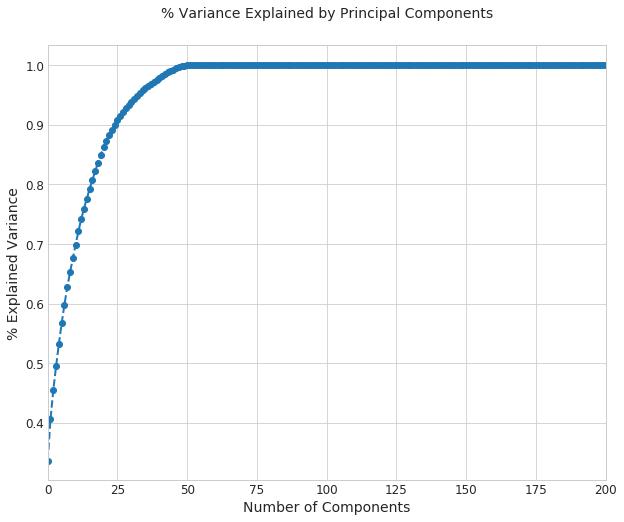

In [47]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [48]:
pca=PCA(n_components=50,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 50 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 50 components is: 0.99917856055


In [49]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [50]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [51]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,50).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.84232712574
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24478  5148    29626
True         313  4696     5009
__all__    24791  9844    34635

Accuracy of the KNN model for twst data is: 0.837048157986
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6071  1311     7382
True         100  1177     1277
__all__     6171  2488     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.855608488523
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29616    10    29626
True        4991    18     5009
__all__    34607    28    34635

Accuracy of the Logistic Regression model for twst data is: 0.852061438965
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7376     6     7382
True        1275     2     1277
__all__     8651     8     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.864674462249
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29576    50    29626
True        4637   372     5009
__all__    34213   422    34635

Accuracy of the Random Forest Classifier for twst data is: 0.856796396813
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7361    21     7382
True        1219    58     1277
__all__     8580    79     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.857456330302
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29603    23    29626
True        4914    95     5009
__all__    34517   118    34635

Accuracy of the Ada Boost Classifier for twst data is: 0.853447280286
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7376     6     7382
True        1263    14     1277
__all__     8639    20     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.86126750397
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29599    27    29626
True        4778   231     5009
__all__    34377   258    34635

Accuracy of the Gradient Boosting Classifier for twst data is: 0.856449936482
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7368    14     7382
True        1229    48     1277
__all__     8597    62     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.865425147972
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29578    48    29626
True        4613   396     5009
__all__    34191   444    34635

Accuracy of the Extra Tree Classifier for twst data is: 0.856796396813
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7359    23     7382
True        1217    60     1277
__all__     8576    83     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.86453009961
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29566    60    29626
True        4632   377     5009
__all__    34198   437    34635

Accuracy of the Bagging model for twst data is: 0.855987989375
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7353    29     7382
True        1218    59     1277
__all__     8571    88     8659



Neural Network-1
The accuracy of the model on training data is: 0.863115345749


Predicted  False  True  __all__
Actual                         
False      29586    40    29626
True        4701   308     5009
__all__    34287   348    34635

The accuracy of the model on test data is: 0.855757015822


Predicted  False  True  __all__
Actual                         
False       7359    23     7382
True        1226    51     1277
__all__     8585    74     8659

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [52]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [53]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.842327,4696.0,24478.0,5148.0,313.0,0.173766,0.062488
LogisticRegression,0.855608,18.0,29616.0,10.0,4991.0,0.000338,0.996406
RandomForestClassifier,0.864674,372.0,29576.0,50.0,4637.0,0.001688,0.925734
AdaBoostClassifier,0.857456,95.0,29603.0,23.0,4914.0,0.000776,0.981034
GradientBoostingClassifier,0.861268,231.0,29599.0,27.0,4778.0,0.000911,0.953883
ExtraTreeClassifier,0.865425,396.0,29578.0,48.0,4613.0,0.001620,0.920942
BaggingClassifier,0.864530,377.0,29566.0,60.0,4632.0,0.002025,0.924735
Neural Network-1,0.863115,308.0,29586.0,40.0,4701.0,0.001350,0.938511


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.837048,1177.0,6071.0,1311.0,100.0,0.177594,0.078309,0.872049
LogisticRegression,0.852061,2.0,7376.0,6.0,1275.0,0.000813,0.998434,0.500377
RandomForestClassifier,0.856796,58.0,7361.0,21.0,1219.0,0.002845,0.954581,0.521287
AdaBoostClassifier,0.853447,14.0,7376.0,6.0,1263.0,0.000813,0.989037,0.505075
GradientBoostingClassifier,0.856450,48.0,7368.0,14.0,1229.0,0.001897,0.962412,0.517846
ExtraTreeClassifier,0.856796,60.0,7359.0,23.0,1217.0,0.003116,0.953015,0.521935
BaggingClassifier,0.855988,59.0,7353.0,29.0,1218.0,0.003928,0.953798,0.521137
Neural Network-1,0.855757,51.0,7359.0,23.0,1226.0,0.003116,0.960063,0.521137


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [54]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,50).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [55]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substr',
 'js_function_.substring(',
 'js_function_.test(

In [56]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [57]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [58]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.893856540084
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24128   5497    29625
True         792  28833    29625
__all__    24920  34330    59250

Accuracy of the KNN model for twst data is: 0.830349924934
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5998  1385     7383
True          84  1192     1276
__all__     6082  2577     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.814565400844
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      19989   9636    29625
True        1351  28274    29625
__all__    21340  37910    59250

Accuracy of the Logistic Regression model for twst data is: 0.71162951842
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       4959  2424     7383
True          73  1203     1276
__all__     5032  3627     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.904860759494
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24213   5412    29625
True         225  29400    29625
__all__    24438  34812    59250

Accuracy of the Random Forest Classifier for twst data is: 0.834622935674
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6012  1371     7383
True          61  1215     1276
__all__     6073  2586     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.856962025316
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22661   6964    29625
True        1511  28114    29625
__all__    24172  35078    59250

Accuracy of the Ada Boost Classifier for twst data is: 0.788890172075
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5641  1742     7383
True          86  1190     1276
__all__     5727  2932     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.882312236287
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23710   5915    29625
True        1058  28567    29625
__all__    24768  34482    59250

Accuracy of the Gradient Boosting Classifier for twst data is: 0.822034877007
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5916  1467     7383
True          74  1202     1276
__all__     5990  2669     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.905316455696
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24224   5401    29625
True         209  29416    29625
__all__    24433  34817    59250

Accuracy of the Extra Tree Classifier for twst data is: 0.834622935674
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6015  1368     7383
True          64  1212     1276
__all__     6079  2580     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.904708860759
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24217   5408    29625
True         238  29387    29625
__all__    24455  34795    59250

Accuracy of the Bagging model for twst data is: 0.832775147246
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5995  1388     7383
True          60  1216     1276
__all__     6055  2604     8659



Neural Network-1
The accuracy of the model on training data is: 0.897164556962


Predicted  False   True  __all__
Actual                          
False      24111   5514    29625
True         579  29046    29625
__all__    24690  34560    59250

The accuracy of the model on test data is: 0.830003464603


Predicted  False  True  __all__
Actual                         
False       5975  1408     7383
True          64  1212     1276
__all__     6039  2620     8659

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [59]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [60]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.893857,28833.0,24128.0,5497.0,792.0,0.185553,0.026734
LogisticRegression,0.814565,28274.0,19989.0,9636.0,1351.0,0.325266,0.045603
RandomForestClassifier,0.904861,29400.0,24213.0,5412.0,225.0,0.182684,0.007595
AdaBoostClassifier,0.856962,28114.0,22661.0,6964.0,1511.0,0.235072,0.051004
GradientBoostingClassifier,0.882312,28567.0,23710.0,5915.0,1058.0,0.199662,0.035713
ExtraTreeClassifier,0.905316,29416.0,24224.0,5401.0,209.0,0.182312,0.007055
BaggingClassifier,0.904709,29387.0,24217.0,5408.0,238.0,0.182549,0.008034
Neural Network-1,0.897165,29046.0,24111.0,5514.0,579.0,0.186127,0.019544


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.830350,1192.0,5998.0,1385.0,84.0,0.187593,0.065831,0.873288
LogisticRegression,0.711630,1203.0,4959.0,2424.0,73.0,0.328322,0.057210,0.807234
RandomForestClassifier,0.834623,1215.0,6012.0,1371.0,61.0,0.185697,0.047806,0.883249
AdaBoostClassifier,0.788890,1190.0,5641.0,1742.0,86.0,0.235947,0.067398,0.848327
GradientBoostingClassifier,0.822035,1202.0,5916.0,1467.0,74.0,0.198700,0.057994,0.871653
ExtraTreeClassifier,0.834623,1212.0,6015.0,1368.0,64.0,0.185291,0.050157,0.882276
BaggingClassifier,0.832775,1216.0,5995.0,1388.0,60.0,0.187999,0.047022,0.882489
Neural Network-1,0.830003,1212.0,5975.0,1408.0,64.0,0.190708,0.050157,0.882489


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [61]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [62]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (12572, 288)


,dom_function_document.captureEvents(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.execCommand(,dom_function_document.getElementById(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.dispatchEvent(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.getComputedStyle(,dom_function_window.getSelection(,dom_function_window.matchMedia(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollTo(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setTimeout(,dom_function_window.stop(,js_function_.add(,js_function_.all(,js_function_.anchor(,js_function_.apply(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_function_.call(,js_function_.catch(,js_function_.charAt(,js_function_.charCodeAt(,js_function_.clear(,js_function_.codePointAt(,js_function_.compile(,js_function_.concat(,js_function_.construct(,js_function_.defineProperty(,js_function_.delete(,js_function_.deleteProperty(,js_function_.endWith(,js_function_.entries(,js_function_.every(,js_function_.exec(,js_function_.fill(,js_function_.filter(,js_function_.find(,js_function_.findIndex(,js_function_.flatMap(,js_function_.fontcolor(,js_function_.forEach(,js_function_.from(,js_function_.get(,js_function_.getDate(,js_function_.getDay(,js_function_.getFullYear(,js_function_.getHours(,js_function_.getInt16(,js_function_.getInt32(,js_function_.getInt8(,js_function_.getMilliseconds(,js_function_.getMinutes(,js_function_.getMonth(,js_function_.getOwnPropertyDescriptor(,js_function_.getPrototypeOf(,js_function_.getSeconds(,js_function_.getTime(,js_function_.getTimezoneOffset(,js_function_.getUTCDate(,js_function_.getUTCDay(,js_function_.getUTCFullYear(,js_function_.getUTCHours(,js_function_.getUTCMilliseconds(,js_function_.getUTCMinutes(,js_function_.getUTCMonth(,js_function_.getUTCSeconds(,js_function_.getUint16(,js_function_.getUint32(,js_function_.getUint8(,js_function_.getYear(,js_function_.has(,js_function_.hasOwnProperty(,js_function_.includes(,js_function_.indexOf(,js_function_.isExtensible(,js_function_.isPrototypeOf(,js_function_.italics(,js_function_.join(,js_function_.keys(,js_function_.lastIndexOf(,js_function_.link(,js_function_.localeCompare(,js_function_.log(,js_function_.map(,js_function_.match(,js_function_.min(,js_function_.next(,js_function_.normalize(,js_function_.of(,js_function_.ownKeys(,js_function_.padEnd(,js_f

In [63]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [64]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [65]:
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substr',
 'js_function_.substring(',
 'js_function_.test(

In [66]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.882370488217
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4071   979     5050
True         204  4803     5007
__all__     4275  5782    10057

Accuracy of the KNN model for twst data is: 0.88310139165
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1018   218     1236
True          76  1203     1279
__all__     1094  1421     2515



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.812270060654
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3395  1655     5050
True         233  4774     5007
__all__     3628  6429    10057

Accuracy of the Logistic Regression model for twst data is: 0.809940357853
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        834   402     1236
True          76  1203     1279
__all__      910  1605     2515



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.898876404494
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4112   938     5050
True          79  4928     5007
__all__     4191  5866    10057

Accuracy of the Random Forest Classifier for twst data is: 0.88986083499
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1019   217     1236
True          60  1219     1279
__all__     1079  1436     2515



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.853833151039
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3870  1180     5050
True         290  4717     5007
__all__     4160  5897    10057

Accuracy of the Ada Boost Classifier for twst data is: 0.851689860835
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        955   281     1236
True          92  1187     1279
__all__     1047  1468     2515



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.873023764542
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4022  1028     5050
True         249  4758     5007
__all__     4271  5786    10057

Accuracy of the Gradient Boosting Classifier for twst data is: 0.873161033797
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1002   234     1236
True          85  1194     1279
__all__     1087  1428     2515



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.900765635876
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4114   936     5050
True          62  4945     5007
__all__     4176  5881    10057

Accuracy of the Extra Tree Classifier for twst data is: 0.891451292247
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1023   213     1236
True          60  1219     1279
__all__     1083  1432     2515



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.898279805111
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4108   942     5050
True          81  4926     5007
__all__     4189  5868    10057

Accuracy of the Bagging model for twst data is: 0.885884691849
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1008   228     1236
True          59  1220     1279
__all__     1067  1448     2515



Neural Network-1
The accuracy of the model on training data is: 0.890623446362


Predicted  False  True  __all__
Actual                         
False       4089   961     5050
True         139  4868     5007
__all__     4228  5829    10057

The accuracy of the model on test data is: 0.888667992048


Predicted  False  True  __all__
Actual                         
False       1016   220     1236
True          60  1219     1279
__all__     1076  1439     2515

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [67]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [68]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.882370,4803.0,4071.0,979.0,204.0,0.193861,0.040743
LogisticRegression,0.812270,4774.0,3395.0,1655.0,233.0,0.327723,0.046535
RandomForestClassifier,0.898876,4928.0,4112.0,938.0,79.0,0.185743,0.015778
AdaBoostClassifier,0.853833,4717.0,3870.0,1180.0,290.0,0.233663,0.057919
GradientBoostingClassifier,0.873024,4758.0,4022.0,1028.0,249.0,0.203564,0.049730
ExtraTreeClassifier,0.900766,4945.0,4114.0,936.0,62.0,0.185347,0.012383
BaggingClassifier,0.898280,4926.0,4108.0,942.0,81.0,0.186535,0.016177
Neural Network-1,0.890623,4868.0,4089.0,961.0,139.0,0.190297,0.027761


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.883101,1203.0,1018.0,218.0,76.0,0.176375,0.059421,0.882102
LogisticRegression,0.809940,1203.0,834.0,402.0,76.0,0.325243,0.059421,0.807668
RandomForestClassifier,0.889861,1219.0,1019.0,217.0,60.0,0.175566,0.046912,0.888761
AdaBoostClassifier,0.851690,1187.0,955.0,281.0,92.0,0.227346,0.071931,0.850361
GradientBoostingClassifier,0.873161,1194.0,1002.0,234.0,85.0,0.189320,0.066458,0.872111
ExtraTreeClassifier,0.891451,1219.0,1023.0,213.0,60.0,0.172330,0.046912,0.890379
BaggingClassifier,0.885885,1220.0,1008.0,228.0,59.0,0.184466,0.046130,0.884702
Neural Network-1,0.888668,1219.0,1016.0,220.0,60.0,0.177994,0.046912,0.884702


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [69]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [70]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')